# Clustering lynx

In [1]:
import random
import torch
import re

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import norm
from gensim.models import Word2Vec
from sklearn.neighbors import NearestNeighbors
from oml.functional.metrics import calc_cmc, calc_map, calc_precision

/gpfslocalsup/pub/anaconda-py3/2023.03/envs/pytorch-gpu-2.0.1+py3.10.12/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
random.seed(42)

In [3]:
# !pip install -U open-metric-learning --user --no-cache-dir
# !pip install gensim --user --no-cache-dir

## Load data

In [4]:
data = pd.read_csv("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_france.csv")
data

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-04-27,NaN,1,0.938,854.8416,1054.8000,558.8352,289.0000
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-05-05,NaN,2,0.894,906.8544,948.9312,997.7472,1628.8128
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-17,NaN,3,0.939,1192.8384,821.8000,743.9040,465.8000
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-16,NaN,4,0.965,834.8832,673.8000,594.8640,518.8000
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Van-Gogh,OCS,NaN,2012-03-05,NaN,5,0.970,765.9080,315.9860,568.8540,392.9500
...,...,...,...,...,...,...,...,...,...,...,...,...
3108,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,2,0.925,668.7360,1152.9216,3805.5744,2295.8208
3109,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,3,0.949,1276.8192,880.9344,3906.6624,2475.8784
3110,/gpfsscratch/rech/ads/commun/datasets/extracte...,679=L192,OFB,SPOTS,2015-07-21,Goumois,4,0.902,615.8804,767.9859,1334.8447,828.8511
3111,/gpfsscratch/rech/ads/commun/datasets/extracte...,1017,OFB,SPOTS,2017-08-08,Chaux-Neuve,1,0.959,1797.7904,835.8592,470.8928,251.9680


### Selection of individuals

We are looking for individuals with around 10 images to test the evaluation metrics.

In [5]:
lynx_id_counts = data['lynx_id'].value_counts()
lynx_id_counts[50:70]

F25-069=J1-2019-1388    16
1342                    16
F25-030=B324            15
704                     15
1504                    14
2208                    14
1509                    14
F25-059=1196=1385       14
2446                    14
F39-091=1724            13
1350=B2011              13
1324                    13
F01-055=1363            13
F25-037                 13
1914                    12
2358                    12
2637                    12
Oslo                    12
2778                    12
F25-039                 11
Name: lynx_id, dtype: int64

In [6]:
selected_individuals = ["Oslo", "2778", "1914"]

In [7]:
data_selected_individuals = data[data["lynx_id"].isin(selected_individuals)]
data_selected_individuals = data_selected_individuals.copy()

### Generation of fake 2D image embeddings

In [8]:
def generate_embedding(lynx_id):
    if lynx_id == "Oslo":
        x = random.randint(0, 4)
        y = random.randint(0, 4)
    elif lynx_id == "1914":
        x = random.randint(6, 10)
        y = random.randint(6, 10)
    else:
        x = random.randint(0, 5)
        y = random.randint(5, 10)
        
    return [x, y]

In [9]:
data_selected_individuals["embedding"] = data_selected_individuals["lynx_id"].apply(generate_embedding)

In [10]:
data_selected_individuals[['embedding_x', 'embedding_y']] = pd.DataFrame(data_selected_individuals['embedding'].tolist(), index=data_selected_individuals.index)

In [11]:
data_selected_individuals.reset_index(drop=True, inplace=True)
data_selected_individuals['lynx_id_int'], _ = pd.factorize(data_selected_individuals["lynx_id"])

data_selected_individuals.head()

,filepath,lynx_id,source,pattern,date,location,image_number,conf,x,y,width,height,embedding,embedding_x,embedding_y,lynx_id_int
0,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2018-11-24,NaN,1,0.918,528.90,522.9640,295.95,168.9220,"[0, 0]",0,0,0
1,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2020-10-03,NaN,2,0.962,851.85,532.9170,255.90,171.9795,"[2, 1]",2,1,0
2,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2018-11-29,NaN,3,0.977,435.90,486.9813,378.00,244.9369,"[1, 1]",1,1,0
3,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2019-12-25,NaN,4,0.947,673.95,508.9643,277.95,147.9803,"[0, 4]",0,4,0
4,/gpfsscratch/rech/ads/commun/datasets/extracte...,Oslo,OCS,NaN,2020-08-31,NaN,5,0.945,158.88,238.9500,181.92,99.9675,"[0, 4]",0,4,0


In [12]:
lynx_int_to_str = pd.Series(data_selected_individuals['lynx_id'].values, index=data_selected_individuals['lynx_id_int'].values).to_dict()
print(lynx_int_to_str)

lynx_str_to_int = {v: k for k, v in lynx_int_to_str.items()}
print(lynx_str_to_int)

{0: 'Oslo', 1: '1914', 2: '2778'}
{'Oslo': 0, '1914': 1, '2778': 2}


## Reception of the image of new candidates

The image is passed to the model and then we obtain an embedding (here 2D). Now, let's run a search using candidates and a NearestNeighbors.

In [13]:
candidates = [
    ([2, 3], "Oslo"),
    ([2, 6], "2778"),
    ([8, 3], "New"),
    ([9, 6], "1914"),
    ([4, 8], "2778"),
    ([4, 2], "Oslo"),
    ([6, 7], "1914")
]

In [14]:
candidates_dots, candidates_id = zip(*candidates)
candidates_dots, candidates_id

(([2, 3], [2, 6], [8, 3], [9, 6], [4, 8], [4, 2], [6, 7]),
 ('Oslo', '2778', 'New', '1914', '2778', 'Oslo', '1914'))

In [15]:
candidates_dots_x, candidates_dots_y = zip(*candidates_dots)

candidates_dots_x, candidates_dots_y

((2, 2, 8, 9, 4, 4, 6), (3, 6, 3, 6, 8, 2, 7))

### Viewing individuals with their embeddings

Text(0.5, 1.0, 'Scatter plot of embeddings with colouring by lynx_id')

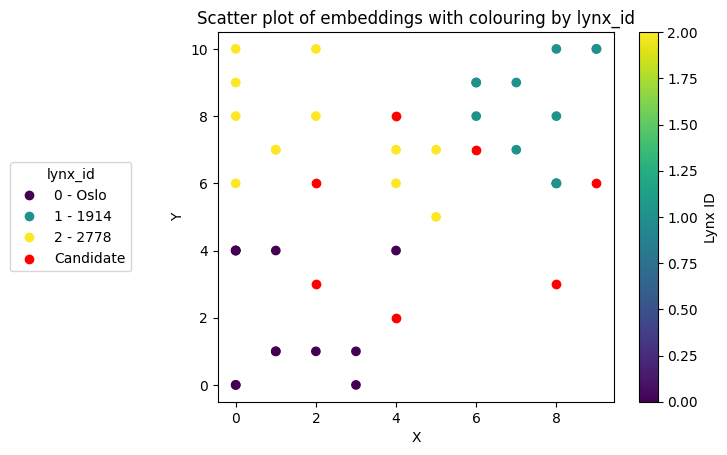

In [16]:
fig, ax = plt.subplots()

scatter = plt.scatter(data_selected_individuals['embedding_x'], data_selected_individuals['embedding_y'], c=data_selected_individuals['lynx_id_int'])
ax.scatter(candidates_dots_x, candidates_dots_y, c='red', marker='o', label='New data')


handles, labels = scatter.legend_elements()
handles.append(ax.scatter([], [], c='red', marker='o'))
labels.append('Candidate')
labels = [re.search(r'\d+', key).group() + ' - ' + lynx_int_to_str[int(re.search(r'\d+', key).group())] if re.search(r'\d+', key) else key for key in labels]
legend = ax.legend(handles, labels, loc="center right", title="lynx_id",  bbox_to_anchor=(-0.2, 0.5))

plt.colorbar(label="Lynx ID")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Scatter plot of embeddings with colouring by lynx_id")

### Nearest Neighbors

In [17]:
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric="minkowski").fit(data_selected_individuals["embedding"].values.tolist())

In [18]:
distances, indices = neighbors.kneighbors(candidates_dots)
distances, indices

(array([[1.41421356, 2.        , 2.23606798, 2.23606798, 2.23606798],
        [1.41421356, 1.41421356, 2.        , 2.        , 2.        ],
        [3.        , 3.        , 3.        , 3.60555128, 4.12310563],
        [1.        , 1.        , 1.        , 2.23606798, 2.23606798],
        [1.        , 1.41421356, 2.        , 2.        , 2.        ],
        [1.41421356, 2.        , 2.23606798, 2.23606798, 3.16227766],
        [1.        , 1.        , 1.        , 2.        , 2.        ]]),
 array([[10,  1, 11,  8,  9],
        [30, 35, 27, 33, 31],
        [21, 13, 17, 28,  8],
        [21, 17, 13, 15, 16],
        [26, 34, 19, 27, 33],
        [11,  8,  5,  1,  7],
        [16, 34, 19, 23, 18]]))

In [19]:
candidates_nearest_neighbors = [
    data_selected_individuals.loc[candidate_indices, "lynx_id"]
    for candidate_indices in indices
]

candidates_nearest_neighbors

[10    Oslo
 1     Oslo
 11    Oslo
 8     Oslo
 9     Oslo
 Name: lynx_id, dtype: object,
 30    2778
 35    2778
 27    2778
 33    2778
 31    2778
 Name: lynx_id, dtype: object,
 21    1914
 13    1914
 17    1914
 28    2778
 8     Oslo
 Name: lynx_id, dtype: object,
 21    1914
 17    1914
 13    1914
 15    1914
 16    1914
 Name: lynx_id, dtype: object,
 26    2778
 34    2778
 19    1914
 27    2778
 33    2778
 Name: lynx_id, dtype: object,
 11    Oslo
 8     Oslo
 5     Oslo
 1     Oslo
 7     Oslo
 Name: lynx_id, dtype: object,
 16    1914
 34    2778
 19    1914
 23    1914
 18    1914
 Name: lynx_id, dtype: object]

In [20]:
candidates_predicted_n_knn = [
    candidate.value_counts().idxmax() for candidate in candidates_nearest_neighbors
]

candidates_predicted_n_knn

['Oslo', '2778', '1914', '1914', '2778', 'Oslo', '1914']

In [21]:
candidates_predicted_1_knn = [
    candidate.iloc[0] for candidate in candidates_nearest_neighbors
]

candidates_predicted_1_knn

['Oslo', '2778', '1914', '1914', '2778', 'Oslo', '1914']

#### Should we reject the individual prediction? Is it a new individual?

In [22]:
cluster_variances = {cluster_indices: np.var(data_selected_individuals[data_selected_individuals['lynx_id_int'] == cluster_indices]['embedding'].to_list(), axis=0) for cluster_indices in [0, 1, 2]}
cluster_variances

{0: array([1.85416667, 3.        ]),
 1: array([1.08333333, 2.30555556]),
 2: array([3.66666667, 2.25      ])}

In [23]:
cluster_means = {cluster_indices: np.mean(data_selected_individuals[data_selected_individuals['lynx_id_int'] == cluster_indices]['embedding'].to_list(), axis=0) for cluster_indices in [0, 1, 2]}
cluster_means

{0: array([1.25, 2.  ]),
 1: array([7.5       , 8.16666667]),
 2: array([2. , 7.5])}

To **find the best value for sigma**, we can try to **find the value which maximises the true positives (rate of well classified known individuals) and the true negatives (rate of well classified unknown individuals)**.

In [24]:
confidence_levels = [0.68, 0.95, 0.99]

In [25]:
def compute_confidence_intervals(confidence, means, variances):
    intervals = []
    for mean, variance in zip(means.values(), variances.values()):
        interval = norm.interval(confidence, loc=mean, scale=np.sqrt(variance))
        intervals.append((np.array([interval[0][0], interval[1][0]]), np.array([interval[0][1], interval[1][1]])))
    
    return intervals

In [26]:
def check_new_individual(candidates_dots, candidates_predicted, candidates_id):
    candidates_predicted_local = candidates_predicted.copy()
    for index, (candidate_dot, candidate_predicted, candidate_id) in enumerate(zip(candidates_dots, candidates_predicted, candidates_id)):
        confidence_intervals_for_candidate = confidence_intervals[lynx_str_to_int[candidate_predicted]]

        in_confidence_interval = all(
            interval[0] <= dot <= interval[1]
            for dot, interval in zip(candidate_dot, confidence_intervals_for_candidate)
        )

        if in_confidence_interval:
            print(f"Candidate {candidate_dot} | Prediction: {candidate_predicted} | True label: {candidate_id}")
        else:
            print(f"Candidate {candidate_dot} | Prediction: new individual | True label: {candidate_id}")
            candidates_predicted_local[index] = "New"
        
    return candidates_predicted_local

In [27]:
def compute_accuracy(candidates_predicted, candidates_refs):
    correct_predictions = sum(p == r for p, r in zip(candidates_predicted, candidates_refs))

    total_predictions = len(candidates_predicted)
    accuracy = correct_predictions/total_predictions
    
    return accuracy

In [28]:
accuracy_list = []

for confidence in confidence_levels:
    print("*"*50, confidence, "*"*50)
    confidence_intervals = compute_confidence_intervals(confidence, cluster_means, cluster_variances)
    candidates_predicted_check = check_new_individual(candidates_dots, candidates_predicted_1_knn, candidates_id)
    accuracy = compute_accuracy(candidates_predicted_check, candidates_id)
    print(f"Accuracy: {accuracy}")
    accuracy_list.append(accuracy)

************************************************** 0.68 **************************************************
Candidate [2, 3] | Prediction: Oslo | True label: Oslo
Candidate [2, 6] | Prediction: new individual | True label: 2778
Candidate [8, 3] | Prediction: new individual | True label: New
Candidate [9, 6] | Prediction: new individual | True label: 1914
Candidate [4, 8] | Prediction: new individual | True label: 2778
Candidate [4, 2] | Prediction: new individual | True label: Oslo
Candidate [6, 7] | Prediction: new individual | True label: 1914
Accuracy: 0.2857142857142857
************************************************** 0.95 **************************************************
Candidate [2, 3] | Prediction: Oslo | True label: Oslo
Candidate [2, 6] | Prediction: 2778 | True label: 2778
Candidate [8, 3] | Prediction: new individual | True label: New
Candidate [9, 6] | Prediction: 1914 | True label: 1914
Candidate [4, 8] | Prediction: 2778 | True label: 2778
Candidate [4, 2] | Prediction

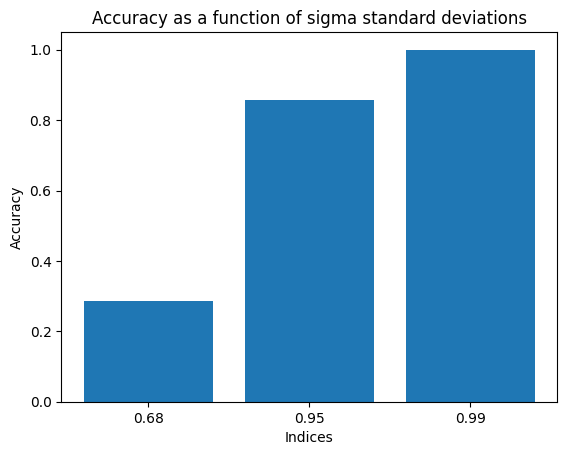

In [29]:
plt.bar([str(conf) for conf in confidence_levels], accuracy_list)
plt.xlabel('Indices')
plt.ylabel('Accuracy')
plt.title('Accuracy as a function of sigma standard deviations')
plt.show()

### Compute the other metrics

Now let's calculate the metrics. To do this, we use the `open-metric-learning` module, which offers ready-made implementations of **CMC@k**, **mAP@k** and **Precision@k**. 

Before calculating the metrics, we need to **adapt `candidates_nearest_neighbors` to the detection of new individuals after our calculation with confidence intervals**. Candidate i, if detected as New, will see its neighbours as "New" from now on.

In [30]:
for index, value in enumerate(candidates_predicted_check):
    if value == "New":
        candidates_nearest_neighbors[index] = candidates_nearest_neighbors[index].apply(lambda x: "New")
        
candidates_nearest_neighbors

[10    Oslo
 1     Oslo
 11    Oslo
 8     Oslo
 9     Oslo
 Name: lynx_id, dtype: object,
 30    2778
 35    2778
 27    2778
 33    2778
 31    2778
 Name: lynx_id, dtype: object,
 21    New
 13    New
 17    New
 28    New
 8     New
 Name: lynx_id, dtype: object,
 21    1914
 17    1914
 13    1914
 15    1914
 16    1914
 Name: lynx_id, dtype: object,
 26    2778
 34    2778
 19    1914
 27    2778
 33    2778
 Name: lynx_id, dtype: object,
 11    Oslo
 8     Oslo
 5     Oslo
 1     Oslo
 7     Oslo
 Name: lynx_id, dtype: object,
 16    1914
 34    2778
 19    1914
 23    1914
 18    1914
 Name: lynx_id, dtype: object]

In [31]:
top_k = (1, 2, 3, 4, 5)

In [32]:
def acc_k_list(nearest_individuals, true_individual):
    return nearest_individuals.apply(lambda x: x == true_individual).tolist()

In [33]:
candidates_acc_k_list = [acc_k_list(neighbors, candidate_id) for neighbors, candidate_id in zip(candidates_nearest_neighbors, candidates_id)]
candidates_acc_k_tensor = torch.tensor(candidates_acc_k_list, dtype=torch.bool)

candidates_acc_k_tensor

tensor([[ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True,  True, False,  True,  True],
        [ True,  True,  True,  True,  True],
        [ True, False,  True,  True,  True]])

#### CMC@k (Cumulative Matching Characteristics) 

In [34]:
calc_cmc(candidates_acc_k_tensor, top_k)

[tensor([1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1.])]

#### mAP@k (mean Average Precision)

In [35]:
n_gt = torch.tensor([5])

In [36]:
calc_map(candidates_acc_k_tensor, n_gt=n_gt, top_k=top_k)

[tensor([1., 1., 1., 1., 1., 1., 1.]),
 tensor([1., 1., 1., 1., 1., 1., 1.]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.8333]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.9167, 1.0000, 0.8056]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.8875, 1.0000, 0.8042])]

#### Precision@k

In [37]:
calc_precision(candidates_acc_k_tensor, n_gt=n_gt, top_k=top_k)

[tensor([1., 1., 1., 1., 1., 1., 1.]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.5000]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.6667, 1.0000, 0.6667]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.7500, 1.0000, 0.7500]),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 0.8000, 1.0000, 0.8000])]